In [1]:
import sys
from typing import Literal

import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Embedding, SimpleRNN, StringLookup
from tensorflow.keras.models import Model

%load_ext autoreload
%autoreload 2

sys.path.append("../")
from equation_discover import *

2023-12-20 17:36:04.295465: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 17:36:04.303686: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 17:36:04.382069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 17:36:04.382098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 17:36:04.384130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
n_samples = 32
sampler = EquationSampler(BASE_TOKENS, 16, 2)
(
    sequences,
    entropies,
    log_probs,
    counters,
    lengths,
    sequence_mask,
) = sampler.sample_sequence(n_samples)

In [ ]:
for sequence, length in zip(sequences, lengths):
    break

In [ ]:
tree = Node.build_tree(sequence[0:length])
tree

In [ ]:
X = pd.DataFrame(np.random.randn(100), columns=["var_x"])
X = {key: tf.convert_to_tensor(value) for key, value in X.to_dict("list").items()}
constants = tf.random.normal([walk(tree, count_constant, current_constant=0)])

In [ ]:
walk(tree, tf_eval, X=X, constants={"value": constants[::-1], "iter": 0})

In [3]:
tree = Node.build_tree(
    [
        BASE_TOKENS.symbols.index(value)
        for value in ["sin", "+", "*", "const", "var_x", "const"]
    ]
)

In [ ]:
X = {
    "var_x": tf.convert_to_tensor(np.linspace(-2 * np.pi, 2 * np.pi), dtype=tf.float32)
}
constants = tf.convert_to_tensor(tf.Variable([2.0, 1.0]))

In [ ]:
go.Figure(
    go.Scatter(
        x=X["var_x"].numpy(),
        y=walk(tree, tf_eval, X=X, constants={"iter": 0, "value": constants}).numpy(),
    )
)

# TODO constraint avoid x / x

In [55]:
from tensorflow.keras.losses import MSE
from scipy.optimize import basinhopping, minimize

In [56]:
X = pd.DataFrame(np.linspace(-2 * np.pi, 2 * np.pi), columns=["var_x"])
y = np.sin((X * 2 + 1).squeeze())

In [57]:
expression = Expression(tree)

In [58]:
results = {}
for T in np.logspace(0, 2, 10):
    res = basinhopping(
        lambda constants: MSE(y, expression.eval(X, constants)),
        expression.constants,
        T=T,
    )
    results[T] = res

In [60]:
[res.x for result in results]

[array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994]),
 array([1.97007085, 0.37227994])]

In [47]:
res = expression.fit(X, y)

In [48]:
expression.constants = res.x

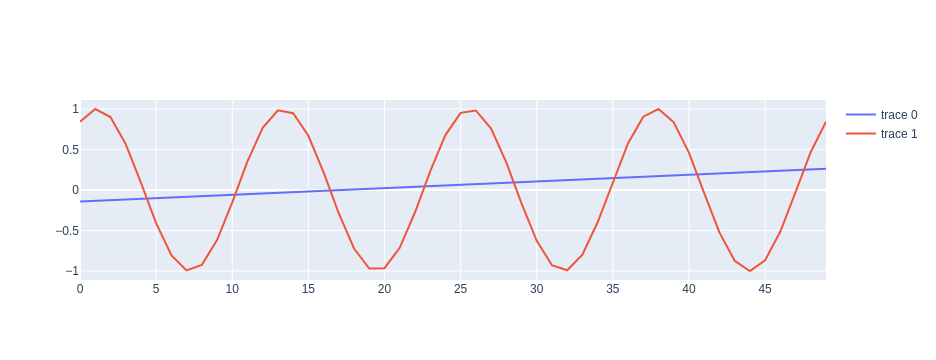

In [49]:
go.Figure(
    [go.Scatter(y=expression.eval(X, res.x)), go.Scatter(y=expression.eval(X, [2, 1]))]
)

In [ ]:
model = EvalModel(tree)
model.compile(optimizer=RMSprop(learning_rate=0.05), loss="mse")
model.fit(
    X,
    y,
    batch_size=X.shape[0],
    epochs=1000,
    callbacks=[
        EarlyStopping(monitor="loss", patience=10, start_from_epoch=10, min_delta=0)
    ],
)
model.constants

In [ ]:
def step(tree, X, y, constants, optimizer: Optimizer):
    with tf.GradientTape() as tape:
        y_pred = walk(tree, tf_eval, X=X, constants={"iter": 0, "value": constants})
        loss = MSE(y, y_pred)
    grads = tape.gradient(loss, constants)
    optimizer.apply_gradients([(grads, constants)])
    return grads, loss


def optimize(
    tree, X: pd.DataFrame, y: pd.Series, constants: tf.Variable, max_steps: int = 100
):
    # optimizer = SGD(learning_rate=0.1)
    optimizer = RMSprop(learning_rate=0.1)

    if isinstance(X, pd.DataFrame):
        X = format_as_dict_of_tensor(X)

    if isinstance(y, pd.Series):
        y = tf.convert_to_tensor(y)

    for n in range(max_steps):
        grads, loss = step(tree, X, y, constants, optimizer)
    return constants


def optimize_constants(tree, X: pd.DataFrame, y: pd.Series, max_steps: int = 100):
    num_constants = walk(tree, count_constant)
    constants = tf.Variable(np.random.randn(num_constants), dtype=tf.float32)
    return optimize(tree, X, y, constants, max_steps)

In [ ]:
X = pd.DataFrame(np.linspace(-2 * np.pi, 2 * np.pi), columns=["var_x"])
y = np.sin((X * 2 + 1).squeeze())

In [ ]:
model.fit(X, y)

In [ ]:
xv, yv = np.meshgrid(np.linspace(-4, 4), np.linspace(-4, 4))

In [ ]:
losses = np.empty_like(xv)
grads = np.empty((50, 50, 2))
for i in range(50):
    for j in range(50):
        constants = tf.Variable([xv[i, j], yv[i, j]])
        with tf.GradientTape() as tape:
            y_pred = walk(tree, tf_eval, X=X, constants={"iter": 0, "value": constants})
            loss = MSE(y, y_pred)
        losses[i, j] = loss.numpy()
        grad = tape.gradient(loss, constants)
        grads[i, j] = grad.numpy()

In [ ]:
go.Figure(
    go.Contour(x=np.linspace(-4, 4), y=np.linspace(-4, 4), z=losses, colorscale="RdBu"),
)

In [ ]:
ff.create_quiver(xv, yv, grads[:, :, 0], grads[:, :, 1], scale=0.05, arrow_scale=0.25)

In [ ]:
losses

In [ ]:
grad

In [ ]:
constants = optimize_constants(tree, X, y)

In [ ]:
constants

In [ ]:
go.Figure(
    [
        go.Scatter(
            x=X.squeeze(),
            y=walk(
                tree, tf_eval, X=X, constants={"iter": 0, "value": constants}
            ).numpy(),
        ),
        go.Scatter(x=X.squeeze(), y=y),
    ]
)